# Exercises XP

## Exercise 1 : Data Import and Initial Exploration

    Import the necessary libraries for data analysis and visualization.

    Load the time-series dataset from the provided file.
    Display the first few rows of the dataset to understand its structure.

    Check the data types of each column and the shape of the dataset.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()
import pandas as pd

from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, GRU
from keras.optimizers import SGD
import math
from sklearn.metrics import mean_squared_error
import zipfile
import os

In [2]:
with zipfile.ZipFile('household_power_consumption.zip', 'r') as zip_ref:
    zip_ref.extractall()

In [3]:
df = pd.read_csv('household_power_consumption.txt', sep=';', na_values=['?'],
                 dtype={'Global_active_power': 'float64', 'Global_reactive_power': 'float64',
                        'Voltage': 'float64', 'Global_intensity': 'float64',
                        'Sub_metering_1': 'float64', 'Sub_metering_2': 'float64',
                        'Sub_metering_3': 'float64'},
                 low_memory=False)


In [4]:
df['DateTime'] = df['Date'] + ' ' + df['Time']
df['DateTime'] = pd.to_datetime(df['DateTime'], format='%d/%m/%Y %H:%M:%S', errors='coerce')
df = df.drop(['Date', 'Time'], axis=1)

In [5]:
df

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,DateTime
0,4.216,0.418,234.84,18.4,0.0,1.0,17.0,2006-12-16 17:24:00
1,5.360,0.436,233.63,23.0,0.0,1.0,16.0,2006-12-16 17:25:00
2,5.374,0.498,233.29,23.0,0.0,2.0,17.0,2006-12-16 17:26:00
3,5.388,0.502,233.74,23.0,0.0,1.0,17.0,2006-12-16 17:27:00
4,3.666,0.528,235.68,15.8,0.0,1.0,17.0,2006-12-16 17:28:00
...,...,...,...,...,...,...,...,...
2075254,0.946,0.000,240.43,4.0,0.0,0.0,0.0,2010-11-26 20:58:00
2075255,0.944,0.000,240.00,4.0,0.0,0.0,0.0,2010-11-26 20:59:00
2075256,0.938,0.000,239.82,3.8,0.0,0.0,0.0,2010-11-26 21:00:00
2075257,0.934,0.000,239.70,3.8,0.0,0.0,0.0,2010-11-26 21:01:00


In [6]:
for i in df.columns:
    print(df[i].dtype)

float64
float64
float64
float64
float64
float64
float64
datetime64[ns]


## Exercise 2 : Handling Missing Values

    Identify columns in the dataset that contain missing values.

    Fill the missing values using the mean of the respective columns.

    Verify that there are no more missing values in the dataset.


In [7]:
df.isna().sum()

Global_active_power      25979
Global_reactive_power    25979
Voltage                  25979
Global_intensity         25979
Sub_metering_1           25979
Sub_metering_2           25979
Sub_metering_3           25979
DateTime                     0
dtype: int64

In [8]:
df = df.fillna(df.mean())

C:\Users\julie\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  """Entry point for launching an IPython kernel.


In [9]:
df.isna().sum()

Global_active_power      0
Global_reactive_power    0
Voltage                  0
Global_intensity         0
Sub_metering_1           0
Sub_metering_2           0
Sub_metering_3           0
DateTime                 0
dtype: int64

## Exercise 3 : Data Visualization

    Resample the ‘Global_active_power’ column over a day and plot the sum and mean values.
    
    Create a plot showing the mean and standard deviation of the ‘Global_intensity’ column resampled over a day.


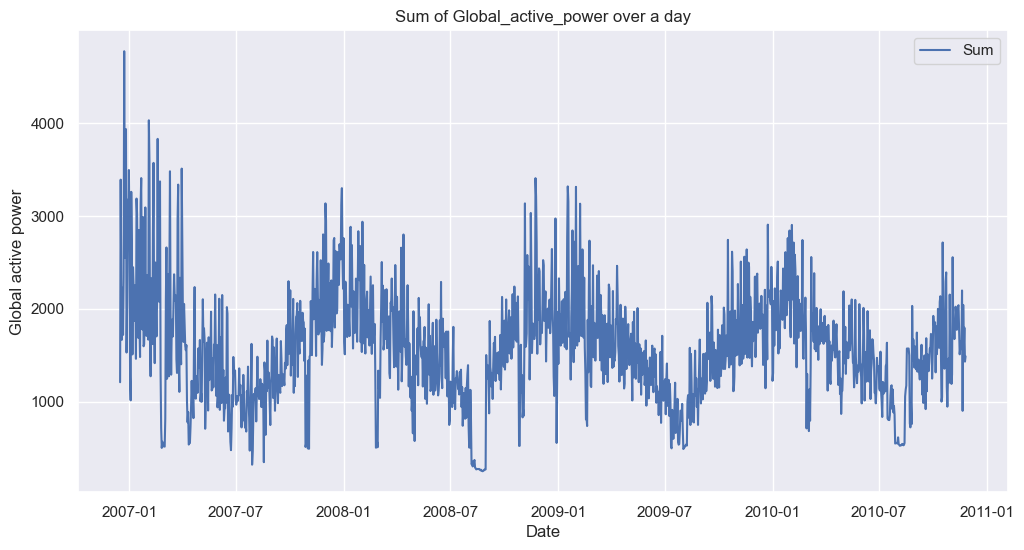

In [10]:
df_resampled_sum = df.resample('D', on='DateTime').sum()
df_resampled_mean = df.resample('D', on='DateTime').mean()

plt.figure(figsize=(12, 6))
sns.lineplot(data=df_resampled_sum['Global_active_power'], label='Sum')
plt.xlabel('Date')
plt.ylabel('Global active power')
plt.title('Sum of Global_active_power over a day')
plt.legend()
plt.show()

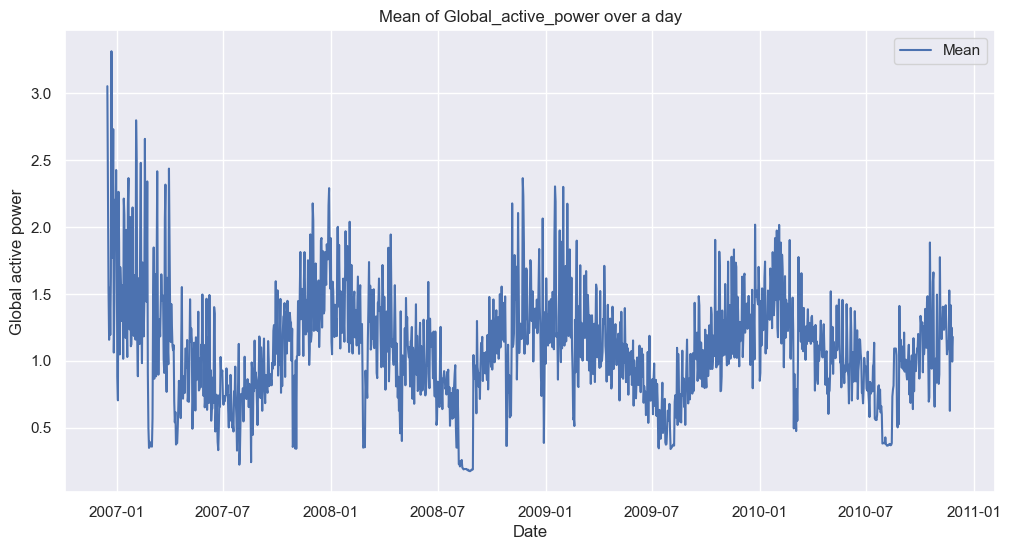

In [11]:
plt.figure(figsize=(12, 6))
sns.lineplot(data=df_resampled_mean['Global_active_power'], label='Mean')
plt.xlabel('Date')
plt.ylabel('Global active power')
plt.title('Mean of Global_active_power over a day')
plt.legend()
plt.show()

There's more energy consumption in cold months.

In [12]:
df_resampled_std = df.resample('D', on='DateTime').std()

plt.figure(figsize=(12, 6))
sns.lineplot(data=df_resampled_std['Global_intensity'], label='Standard deviation')
sns.lineplot(data=df_resampled_mean['Global_intensity'], label='Mean')
plt.xlabel('Date')
plt.ylabel('Global intensity')
plt.title('Mean and standard deviation of Global_intensity over a day')
plt.legend()

## Exercise 4 : Data Preprocessing for LSTM

    Normalize the dataset to prepare it for LSTM model training.

    Split the dataset into training and testing sets.
    
    Reshape the data to fit the input requirements of an LSTM model.


In [13]:
train_size = int(len(df) * 0.8)
test_size = len(df) - train_size
train, test = df[0:train_size], df[train_size:len(df)]

In [14]:
sc = MinMaxScaler(feature_range=(0, 1))
def scale_data(df):
    df_date = df['DateTime']
    df_numerical = df.drop(columns=['DateTime'])
    df_numerical_scaled = pd.DataFrame(sc.fit_transform(df_numerical), columns=df_numerical.columns, index=df_numerical.index)
    #df_scaled = pd.concat([df_date, df_numerical_scaled], axis=1)
    return df_numerical_scaled

train_scaled = scale_data(train)
test_scaled = scale_data(test)

In [15]:
def create_sequences(data, time_steps=1):
    x, y = [], []
    for i in range(len(data) - time_steps):
        x.append(data[i:(i + time_steps)])
        y.append(data[i + time_steps])
    return np.array(x), np.array(y)

In [16]:
features = ['Global_active_power', 'Global_reactive_power']

train_selected = train_scaled[features]
time_steps = 60
X_train, y_train = create_sequences(train_scaled.values, time_steps)
X_test, y_test = create_sequences(test_scaled.values, time_steps)

## Exercise 5 : Building an LSTM Model

    Import the necessary libraries for building an LSTM model.

    Define the architecture of the LSTM model, including the number of layers and neurons.
    
    Compile the model with an appropriate loss function and optimizer.


In [17]:
from keras.optimizers import Adam

model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=X_train.shape[1:]))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=1))
model.compile(optimizer=Adam(learning_rate=0.01), loss='mean_squared_error', metrics=['mae'])

## Exercise 6 : Training and Evaluating the LSTM Model

    Train the LSTM model on the training dataset.

    Evaluate the model’s performance on the testing dataset.
    
    Plot the training and validation loss to assess the model’s learning progress.


In [18]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(X_train, y_train,
                    epochs=5, 
                    batch_size=64,  
                    validation_data=(X_test, y_test), 
                    verbose=1,
                    callbacks=[early_stopping])  

Epoch 1/5
25940/25940 [==============================] - 1529s 59ms/step - loss: 0.0450 - mae: 0.1617 - val_loss: 0.0445 - val_mae: 0.1603
Epoch 2/5
25940/25940 [==============================] - 1592s 61ms/step - loss: 0.0449 - mae: 0.1616 - val_loss: 0.0445 - val_mae: 0.1640
Epoch 3/5
25940/25940 [==============================] - 1758s 68ms/step - loss: 0.0451 - mae: 0.1623 - val_loss: 0.0451 - val_mae: 0.1622
Epoch 4/5
25940/25940 [==============================] - 2214s 85ms/step - loss: 0.0455 - mae: 0.1639 - val_loss: 0.0450 - val_mae: 0.1661
Epoch 5/5
25940/25940 [==============================] - 2591s 100ms/step - loss: 0.0457 - mae: 0.1646 - val_loss: 0.0454 - val_mae: 0.1677


In [19]:
test_mse, test_mae = model.evaluate(X_test, y_test)
print(f'MSE: {test_mse}')
print(f'MAE: {test_mae}')

12969/12969 [==============================] - 267s 21ms/step - loss: 0.0454 - mae: 0.1677
Test Loss: [0.04541923478245735, 0.1676563024520874]


Since the values are between 0 and 1 this doesn't seem to be a great result. This took a few hours to run so I don't have time to improve it.

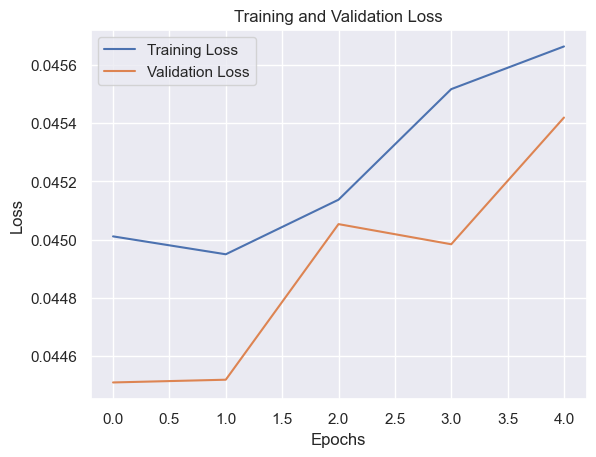

In [21]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

The loss increased with the Epochs. This isn't a good sign for the model.